#**A. Pre-Requisites**

In [ ]:
%%capture
# 1. Kaggle Installation
!pip install kaggle

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Download Kaggle Data directly into Colab
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/COMP700/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# **B. Install the Required Libraries**

In [ ]:
%%capture

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install datasets # to prepare data
!pip install -q monai # to use special loss functions, specifically for medical image applications

!pip install patchify # to divide large images into smaller patches for training (not necessary for smaller images)
!pip install nibabel # to read and write to common neuroimaging file formats e.g. NifTI1, NifTI2 file formats

# **1. REFUGE Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download arnavjain1/glaucoma-datasets
!unzip -q glaucoma-datasets.zip

Dataset URL: https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.54G/5.55G [01:24<00:00, 83.0MB/s]
100% 5.55G/5.55G [01:24<00:00, 70.3MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing images and masks
image_dir = '/content/REFUGE/val/Images'  # Directory with image .png or .jpg files
mask_dir = '/content/REFUGE/val/gts'  # Directory with mask .bmp files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size, file_extensions=('.png', '.jpg', '.bmp')):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.lower().endswith(file_extensions):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)  # Load images (.png/.jpg)
large_masks = load_images_from_folder(mask_dir, resize_to, file_extensions=('.bmp',))  # Load masks (.bmp)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 400 images of shape (256, 256) (HxW)
Loaded 400 masks of shape (256, 256) (HxW)
Image shape: (400, 256, 256)
Mask shape: (400, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

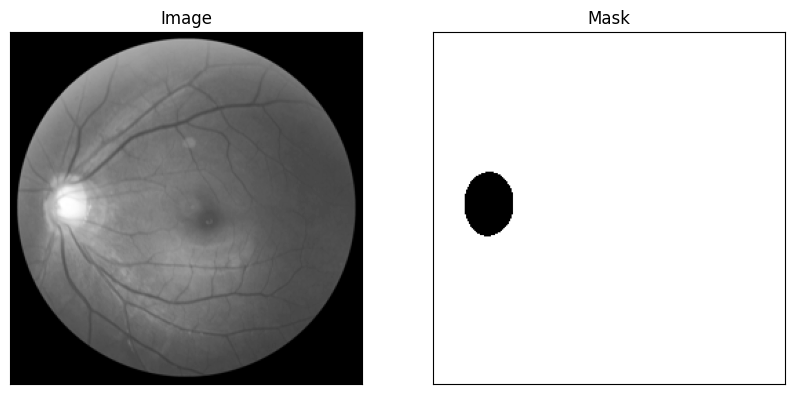

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **2. Hi-gMISnet_all Dataset (Medical Image Segmentation Datasets)**
Hi-gMISnet_all_dataset contains:


1.   BUSI (**B**reast **U**ltra**S**ound **I**mages)
2.   CVC_CLINIC_DB (CVC Clinic Database for colonoscopy video analysis)
3.   GLAS (**Gla**nd **S**egmentation - in Colon Histology Images)
4.   ISIC_2018 (**I**nternal **S**kin **I**maging **C**ollaboration 2018)
5.   MoNuSeg (**M**ulti-**O**rgan **Nu**clei **S**egmentation)
6.   Montgomery_County (Montgomery County X-ray Set - for TB Detection)
7.   PROMISE12 (**Pro**state **M**R **I**mage **Se**gmentation)
8.   Physionet_ICH (Physionet **I**ntra**C**ranial **H**emorrhage)



## Download Dataset

In [ ]:
!kaggle datasets download tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
!unzip -q medical-image-segmentation-datasets-hi-gmisnet.zip

Dataset URL: https://www.kaggle.com/datasets/tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
License(s): MIT
100% 1.70G/1.70G [00:26<00:00, 80.2MB/s]
100% 1.70G/1.70G [00:26<00:00, 69.7MB/s]


## **2.1. Physionet_ICH Dataset**

### Create the Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/Physionet_ICH/val/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/Physionet_ICH/val/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 32 images of shape (256, 256) (HxW)
Loaded 32 masks of shape (256, 256) (HxW)
Image shape: (32, 256, 256)
Mask shape: (32, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32
})

### Save the Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/physionet_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/physionet_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32
})

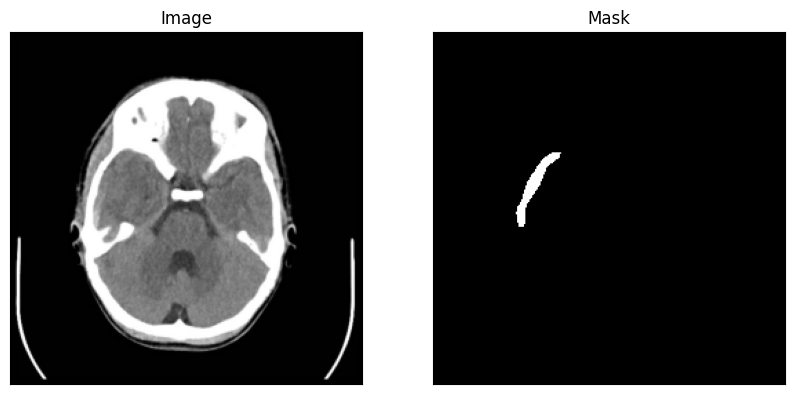

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.2. MoNuSeg Dataset**

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/MoNuSeg/validation folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/MoNuSeg/validation folder/labelcol'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 6 images of shape (256, 256) (HxW)
Loaded 6 masks of shape (256, 256) (HxW)
Image shape: (6, 256, 256)
Mask shape: (6, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6
})

### Save Dataset to Drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/monuseg_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the created dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/monuseg_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6
})

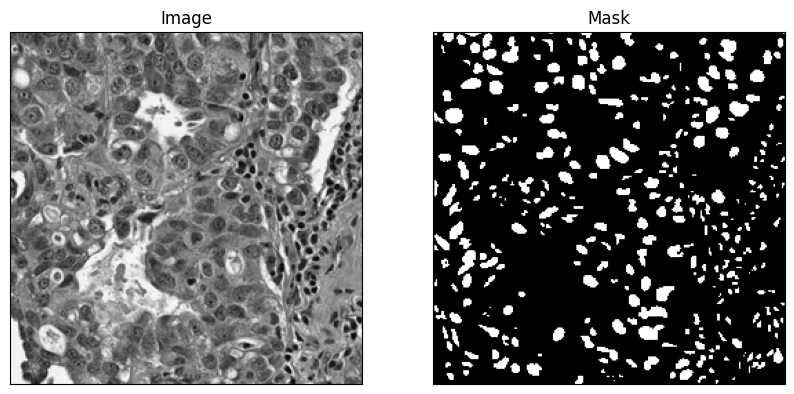

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.3. GLAS Dataset (*)**

### Create Dataset from GLAS

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/GLAS/Validation Folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/GLAS/Validation Folder/labelcol'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 13 images of shape (256, 256) (HxW)
Loaded 13 masks of shape (256, 256) (HxW)
Image shape: (0, 256, 256)
Mask shape: (0, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 0
})

Save the created dataset into the drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/glas_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


### Load the GLAS Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/glas_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Display an example image and mask to check if dataset loads properly

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.4. BUSI Dataset**

### Create Dataset from BUSI

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/BUSI/val_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/BUSI/val_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 65 images of shape (256, 256) (HxW)
Loaded 65 masks of shape (256, 256) (HxW)
Image shape: (65, 256, 256)
Mask shape: (65, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 65
})

Save the dataset into Drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the BUSI Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 65
})

Make sure the dataset is working properly after loading from drive

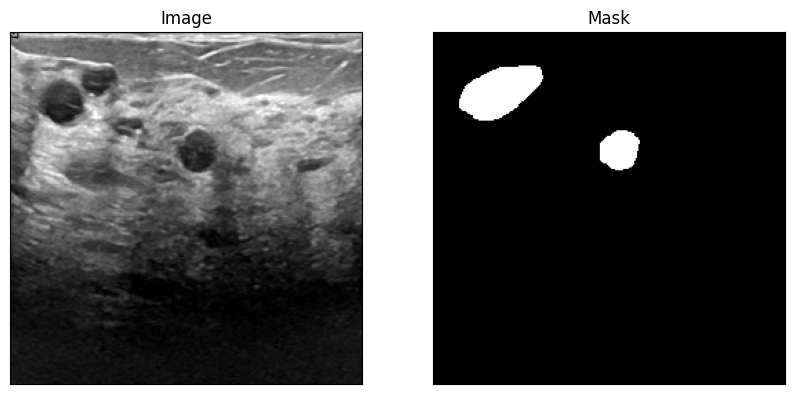

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.5. CVC_Clinic_DB**

### Create Dataset from CVC_CLINIC_DB

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/CVC_clinic_DB/validation/validation folder/img'  # Directory with image .jpg files
mask_dir = '/content/Hi-gMISnet_all_dataset/CVC_clinic_DB/validation/validation folder/label'    # Directory with mask .jpg files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 61 images of shape (256, 256) (HxW)
Loaded 61 masks of shape (256, 256) (HxW)
Image shape: (61, 256, 256)
Mask shape: (61, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 61
})

Save the created dataset into the drive

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_clinic_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the CVC_Clinic Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_clinic_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 61
})

Make sure the dataset loads images and masks properly

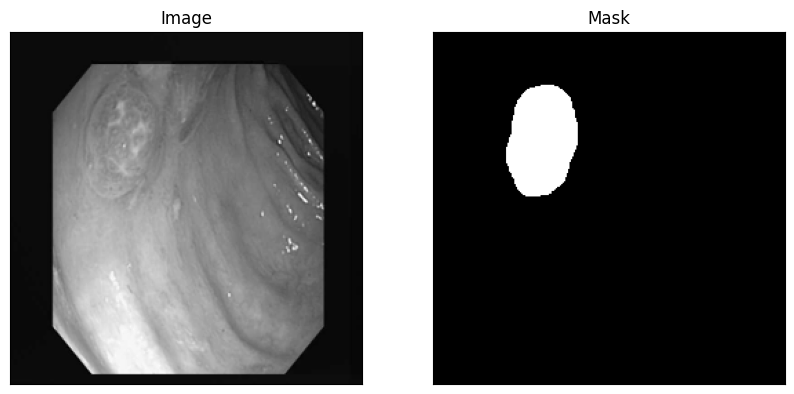

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.6. PROMISE12 Dataset**

Prostate MRI Segmentation

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/validation_data/image'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/validation_data/mask'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 277 images of shape (256, 256) (HxW)
Loaded 277 masks of shape (256, 256) (HxW)
Image shape: (277, 256, 256)
Mask shape: (277, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 277
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 277
})

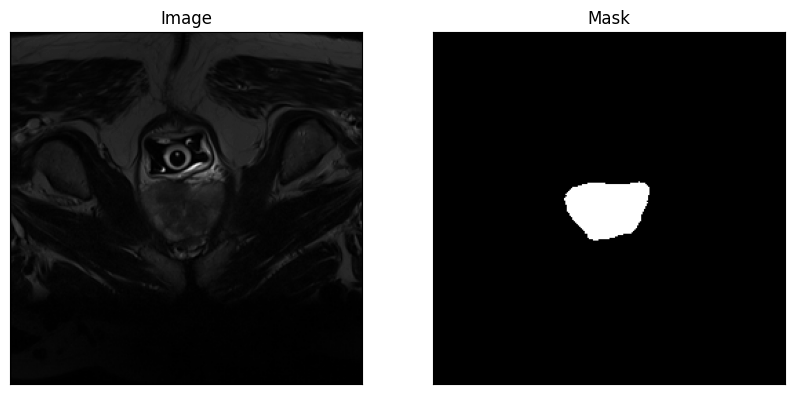

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.7. ISIC2018 Dataset**

Internal Skin Imaging Collaboration

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/val_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/val_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 260 images of shape (256, 256) (HxW)
Loaded 260 masks of shape (256, 256) (HxW)
Image shape: (260, 256, 256)
Mask shape: (260, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 260
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 260
})

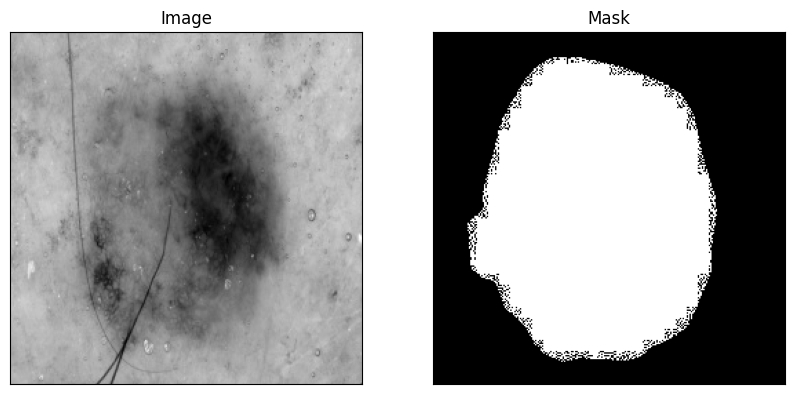

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **2.7. Montgomery County Dataset**

Chest X-Ray

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/val_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/val_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 14 images of shape (256, 256) (HxW)
Loaded 14 masks of shape (256, 256) (HxW)
Image shape: (14, 256, 256)
Mask shape: (14, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_valid_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_valid_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14
})

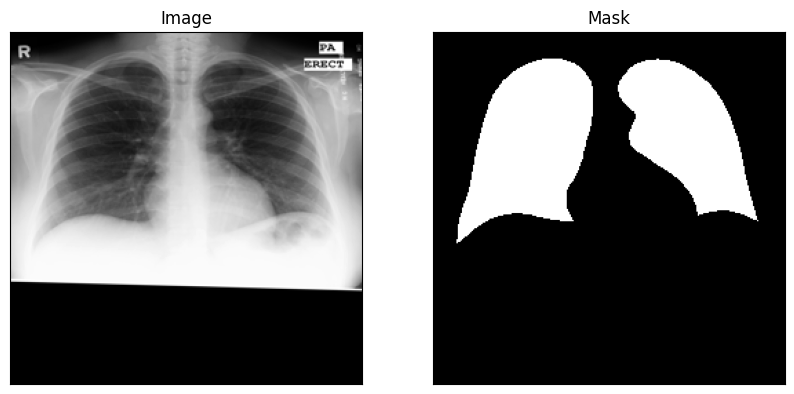

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()